1.1.7

Processing MRNA data...
(518, 4359)
Train Patients: 327, Val Patients: 82, Test Patients: 103
Mask shape: (173, 4359)


PCA for mrna: 100%|██████████| 173/173 [00:07<00:00, 22.80it/s]


min/max of pca for datatype MRNA: min=-0.7259, max=0.9530


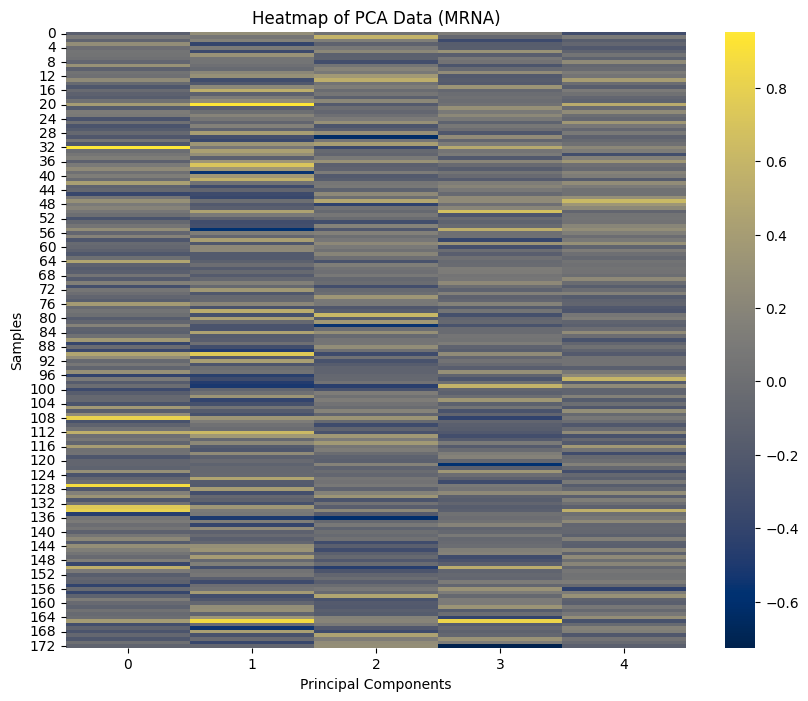


Processing CNA data...
(517, 4545)
Train Patients: 327, Val Patients: 82, Test Patients: 103
Mask shape: (173, 4545)


PCA for cna: 100%|██████████| 173/173 [00:08<00:00, 19.94it/s]


min/max of pca for datatype CNA: min=-1.2782, max=1.5045


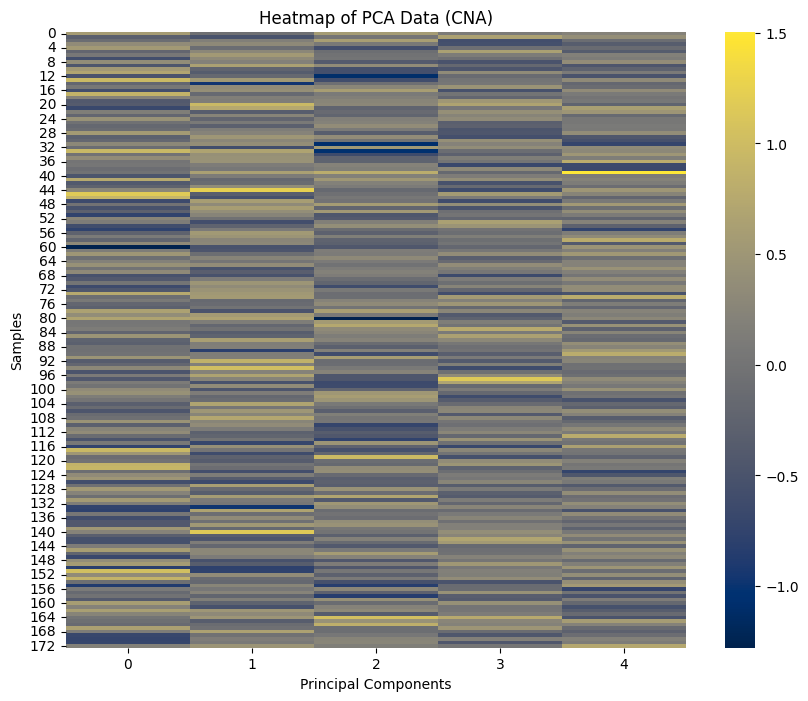


Processing DM data...
(581, 501)
Train Patients: 327, Val Patients: 82, Test Patients: 103
Mask shape: (173, 501)


PCA for dm:   0%|          | 0/173 [00:00<?, ?it/s]/Users/alimomennasab/opt/anaconda3/envs/pathcnnEnv/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:789: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var
PCA for dm:  29%|██▉       | 50/173 [00:00<00:01, 109.38it/s]/Users/alimomennasab/opt/anaconda3/envs/pathcnnEnv/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:789: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var
PCA for dm:  71%|███████   | 123/173 [00:00<00:00, 136.01it/s]/Users/alimomennasab/opt/anaconda3/envs/pathcnnEnv/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:789: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var
/Users/alimomennasab/opt/anaconda3/envs/pathcnnEnv/lib/python3.12/site-packages/sklearn/decomposition/_pca.py

min/max of pca for datatype DM: min=-1.1523, max=0.8444


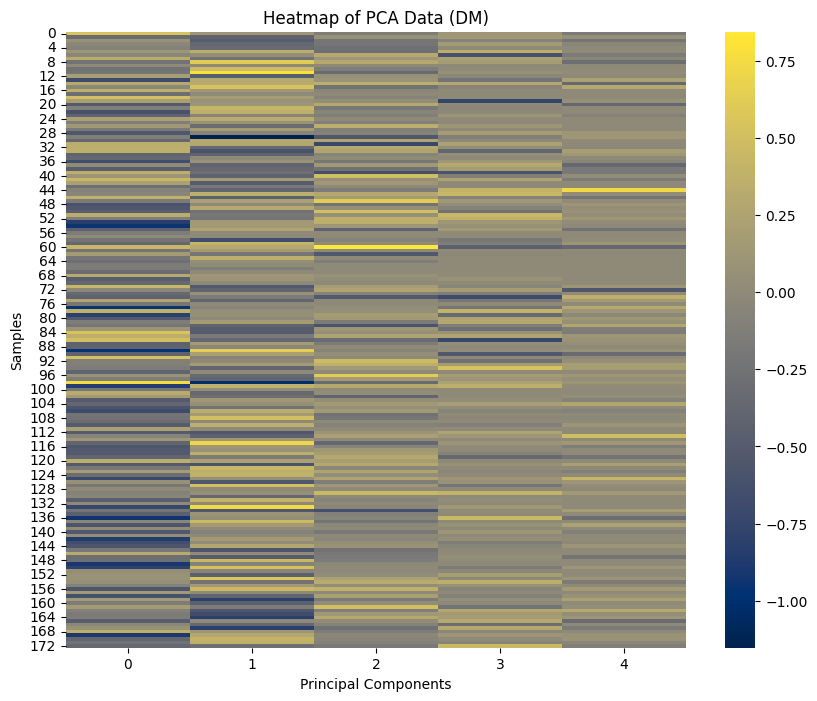


All data processing completed!


In [36]:
import pandas as pd
#from cuml.decomposition import PCA
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os
import pandas as pd 
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy
from gseapy.parser import read_gmt
print(gseapy.__version__)

def read_gmt_file(gmt_file_path):
    """
    Reads a GMT file and returns a dictionary representing the gene sets.

    Args:
        gmt_file_path (str): The path to the GMT file.

    Returns:
        dict: A dictionary where keys are gene set names and values are lists of genes.
    """
    try:
        gene_sets = read_gmt(gmt_file_path)
        return gene_sets
    except FileNotFoundError:
        print(f"Error: GMT file not found at {gmt_file_path}")
        return None
    except ValueError as e:
         print(f"ValueError: {e}")
         return None


def pathway_reader(gmt_file):

    gene_sets_data = read_gmt_file(gmt_file)
    dict_p = {}
    counter = 0
    counter_len = 0
    if gene_sets_data:
        # Access gene sets data
        for gene_set_name, genes in gene_sets_data.items():
            # print(f"Gene set: {gene_set_name}")
            # print(f"Genes: {genes[:2]}")  
            # print(f"length: {len(genes)}...\n")
            if gene_set_name[:4] == "KEGG" and "KEGG_MEDICUS" not in gene_set_name:

                if(len(genes)>15 and len(genes)<300):
                    dict_p[gene_set_name] = genes
                    counter = counter +1# Print first 10 genes for brevity
    else:
        print("Failed to read GMT file.")
    # print(counter)
    return dict_p

def intersection(pathway,genes):
    intersection_ = list(set(genes) & set(pathway))
    return intersection_
def pathway_mask(Genes,path_dict):
    p_mask = []
    for pathway_name in path_dict.keys():
        pathway = path_dict[pathway_name]
        intersection__ = intersection(pathway,Genes.columns)
        msk = []
        # print(Genes.columns)
        for j in Genes.columns:
            
            if j in intersection__:
                msk.append(1)
            else:
                msk.append(0)
        p_mask.append(msk)
    return p_mask

gmt_file = "/Users/alimomennasab/Desktop/PathCNN and HipoCNN/PathCNN PCA Gen/data/c2.cp.v2024.1.Hs.symbols.gmt"
path_dict = pathway_reader(gmt_file)
unique_values = set(val for values in path_dict.values() for val in values)

# Define all input files
input_files = {
    'mrna': "/Users/alimomennasab/Desktop/PathCNN and HipoCNN/PathCNN PCA Gen/data/data_mrna_seq_v2_rsem.txt",
    'cna': "/Users/alimomennasab/Desktop/PathCNN and HipoCNN/PathCNN PCA Gen/data/data_cna.tsv",
    'dm': "/Users/alimomennasab/Desktop/PathCNN and HipoCNN/PathCNN PCA Gen/data/combined_methylation_data.tsv"
}

# Define output folders
output_folders = {
    'mrna': '/Users/alimomennasab/Desktop/PathCNN and HipoCNN/PathCNN PCA Gen/data/new_pca/mrna',
    'cna': '/Users/alimomennasab/Desktop/PathCNN and HipoCNN/PathCNN PCA Gen/data/new_pca/cna',
    'dm': '/Users/alimomennasab/Desktop/PathCNN and HipoCNN/PathCNN PCA Gen/data/new_pca/dm'
}

# Create output folders if they don't exist
for folder in output_folders.values():
    os.makedirs(folder, exist_ok=True)

# Process each file type
for data_type, input_file in input_files.items():
    print(f"\nProcessing {data_type.upper()} data...")
    
    # Load data
    # if data_type == 'cna':
    #     Gene = pd.read_csv(input_file, sep="\t")
    # else:
    Gene = pd.read_csv(input_file, sep="\t")
    Gene = Gene.T
    new_header = Gene.iloc[0] #grab the first row for the header
    Gene = Gene[1:] #take the data without the header row
    Gene.columns = new_header
    
    Gene = Gene[Gene.columns.intersection(unique_values)]
    print(Gene.shape)

    # Process patient IDs
    #Gene.index = Gene.index.str.replace(r'-01$', '', regex=True)
    Gene.index = Gene.index.astype(str).str.replace(r'-01$', '', regex=True)

    # Load labeled data
    labeled_data_path = '/Users/alimomennasab/Desktop/PathCNN and HipoCNN/HipoCNN/data/labeled_dataset.csv'
    labeled_data = pd.read_csv(labeled_data_path)
    labeled_data = labeled_data.drop(0) # remove header

    train_patients = labeled_data[labeled_data['label'] == 'train']['Patient ID'].tolist()
    val_patients = labeled_data[labeled_data['label'] == 'val']['Patient ID'].tolist()
    test_patients = labeled_data[labeled_data['label'] == 'test']['Patient ID'].tolist()
    print(f"Train Patients: {len(train_patients)}, Val Patients: {len(val_patients)}, Test Patients: {len(test_patients)}")

    # Split data
    Train = Gene[Gene.index.isin(train_patients)]
    Validation = Gene[Gene.index.isin(val_patients)]
    Test = Gene[Gene.index.isin(test_patients)]

    # Create pathway masks
    p_mask = pathway_mask(Gene, path_dict)
    p_mask = np.array(p_mask)
    print(f"Mask shape: {p_mask.shape}")

    # Scale data
    scaler = MinMaxScaler()
    scaler.fit(Train)
    Train_scaled = scaler.transform(Train)
    Validation_scaled = scaler.transform(Validation)
    Test_scaled = scaler.transform(Test)

    # Apply pathway masks
    def data_path(data_, p_mask):
        List_data = []
        for i, row in enumerate(data_):
            row = np.array(row)
            gene_img = p_mask*row
            List_data.append(gene_img)
        return np.asarray(List_data)

    Train_data = data_path(Train_scaled, p_mask)
    Validation_data = data_path(Validation_scaled, p_mask)
    Test_data = data_path(Test_scaled, p_mask)

    # Transpose for PCA
    Train_data = np.transpose(Train_data, (1, 0, 2))
    Validation_data = np.transpose(Validation_data, (1, 0, 2))
    Test_data = np.transpose(Test_data, (1, 0, 2))

    # Perform PCA
    List_pca_train = []
    List_pca_val = []
    List_pca_test = []
    
    for i in tqdm(range(Train_data.shape[0]), desc=f"PCA for {data_type}"):
        pca = PCA(n_components=5)
        pca.fit(Train_data[i])

        List_pca_train.append(pca.transform(Train_data[i]))
        List_pca_val.append(pca.transform(Validation_data[i]))
        List_pca_test.append(pca.transform(Test_data[i]))

    # Prepare final outputs
    List_pca_train = np.transpose(np.asarray(List_pca_train), (1, 0, 2))
    List_pca_val = np.transpose(np.asarray(List_pca_val), (1, 0, 2))
    List_pca_test = np.transpose(np.asarray(List_pca_test), (1, 0, 2))

    # Save individual PCA results (train, test, val)
    row_labels = pd.Series(Gene.index)
    #for i, label in enumerate(row_labels):
    for i in range(len(List_pca_test)):
        filename = os.path.join(output_folders[data_type], f"{data_type}-{test_patients[i]}.npy")
        np.save(filename, List_pca_test[1])

    for i in range(len(List_pca_train)):
        filename = os.path.join(output_folders[data_type], f"{data_type}-{train_patients[i]}.npy")
        np.save(filename, List_pca_train[1])

    for i in range(len(List_pca_val)):
        filename = os.path.join(output_folders[data_type], f"{data_type}-{val_patients[i]}.npy")
        np.save(filename, List_pca_val[1])

    print(f"min/max of pca for datatype {data_type.upper()}: min={np.min(List_pca_test[1]):.4f}, max={np.max(List_pca_test[1]):.4f}")

    plt.figure(figsize=(10, 8))
    sns.heatmap(List_pca_test[1], cmap='cividis')
    plt.title(f"Heatmap of PCA Data ({data_type.upper()})")
    plt.xlabel("Principal Components")
    plt.ylabel("Samples")
    plt.show()

print("\nAll data processing completed!")

In [37]:
"""This code combines corresponding files within the MRNA, DM, and CNA datasets."""

def load_folder_except_ID_file(folder_path, exclude_file):
    data = {}
    for filename in os.listdir(folder_path):
        if filename != exclude_file:
            file_path = os.path.join(folder_path, filename)
            data[filename] = np.load(file_path)
    return data


# cna_sample_foldername = 'cna_samples'
# dm_sample_foldername = 'dm_samples'
# mrna_sample_foldername = 'mrna_samples'

cna_sample_path = '/Users/alimomennasab/Desktop/PathCNN and HipoCNN/PathCNN PCA Gen/data/new_pca/cna'
dm_sample_foldername = '/Users/alimomennasab/Desktop/PathCNN and HipoCNN/PathCNN PCA Gen/data/new_pca/dm'
mrna_sample_foldername = '/Users/alimomennasab/Desktop/PathCNN and HipoCNN/PathCNN PCA Gen/data/new_pca/mrna'


# load each folder as an np array EXCEPT for the file with the name {type}-Entrez_Gene_Id.npy
cna_data = load_folder_except_ID_file(cna_sample_path, 'cna-Entrez_Gene_Id.npy')
dm_data = load_folder_except_ID_file(dm_sample_foldername, 'dm-Entrez_Gene_Id.npy')
mrna_data = load_folder_except_ID_file(mrna_sample_foldername, 'mrna-Entrez_Gene_Id.npy')

# go down the list of CNA files. extract the name of the file, and use that to get the corresponding DM and MRNA data
combined_data = {}
for cna_filename in cna_data:
    
    dm_filename = cna_filename.replace('cna', 'dm')
    mrna_filename = cna_filename.replace('cna', 'mrna')
    
    # Check if the corresponding DM and MRNA files exist
    if dm_filename not in dm_data:
        print(f"Warning: {dm_filename} not found in DM data. Skipping.")
        continue
    if mrna_filename not in mrna_data:
        print(f"Warning: {mrna_filename} not found in MRNA data. Skipping.")
        continue
    
    cna_sample = cna_data[cna_filename]
    dm_sample = dm_data[dm_filename]
    mrna_sample = mrna_data[mrna_filename]
    #print(f"max of mrna for file{mrna_filename}: ", max(mrna_sample))
    
    combined_sample = np.concatenate((cna_sample, dm_sample, mrna_sample), axis=1)
    #print(f"max - {max(combined_sample)}")
    
    combined_data[cna_filename] = combined_sample
    print("Combined sample shape: ", combined_sample.shape)

print("Number of combined PCAs: ", len(combined_data))

# save combined data to a folder, with the "cn" in each file being replaced with pca
combined_path = 'data/new_pca/combined_PCA_samples'
os.makedirs(combined_path, exist_ok=True)
for filename, data in combined_data.items():
    pca_filename = filename.replace('cna', 'pca')
    pca_filepath = os.path.join(combined_path, pca_filename)
    np.save(pca_filepath, data)


Combined sample shape:  (173, 15)
Combined sample shape:  (173, 15)
Combined sample shape:  (173, 15)
Combined sample shape:  (173, 15)
Combined sample shape:  (173, 15)
Combined sample shape:  (173, 15)
Combined sample shape:  (173, 15)
Combined sample shape:  (173, 15)
Combined sample shape:  (173, 15)
Combined sample shape:  (173, 15)
Combined sample shape:  (173, 15)
Combined sample shape:  (173, 15)
Combined sample shape:  (173, 15)
Combined sample shape:  (173, 15)
Combined sample shape:  (173, 15)
Combined sample shape:  (173, 15)
Combined sample shape:  (173, 15)
Combined sample shape:  (173, 15)
Combined sample shape:  (173, 15)
Combined sample shape:  (173, 15)
Combined sample shape:  (173, 15)
Combined sample shape:  (173, 15)
Combined sample shape:  (173, 15)
Combined sample shape:  (173, 15)
Combined sample shape:  (173, 15)
Combined sample shape:  (173, 15)
Combined sample shape:  (173, 15)
Combined sample shape:  (173, 15)
Combined sample shape:  (173, 15)
Combined sampl

data size of combined sample:  2595


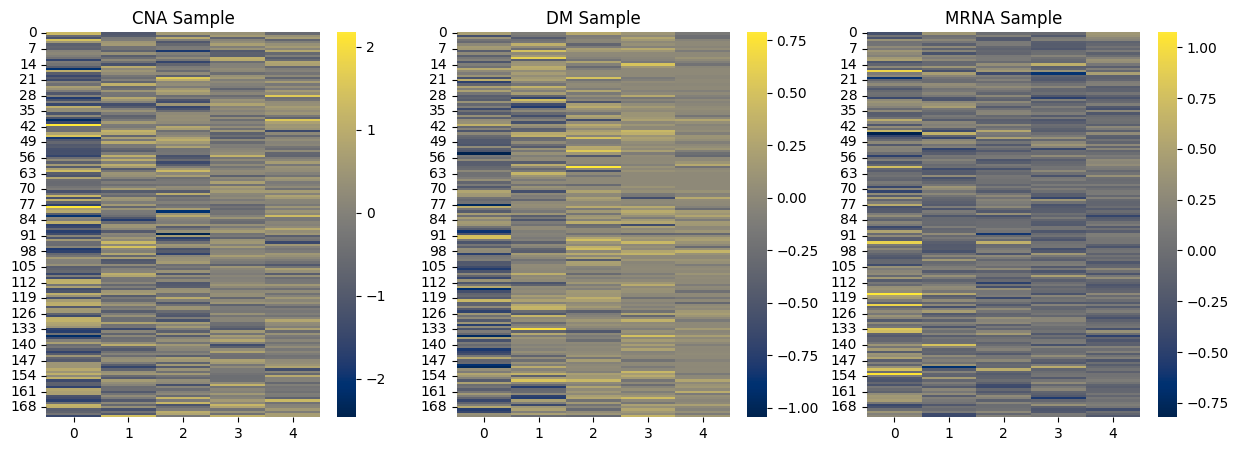

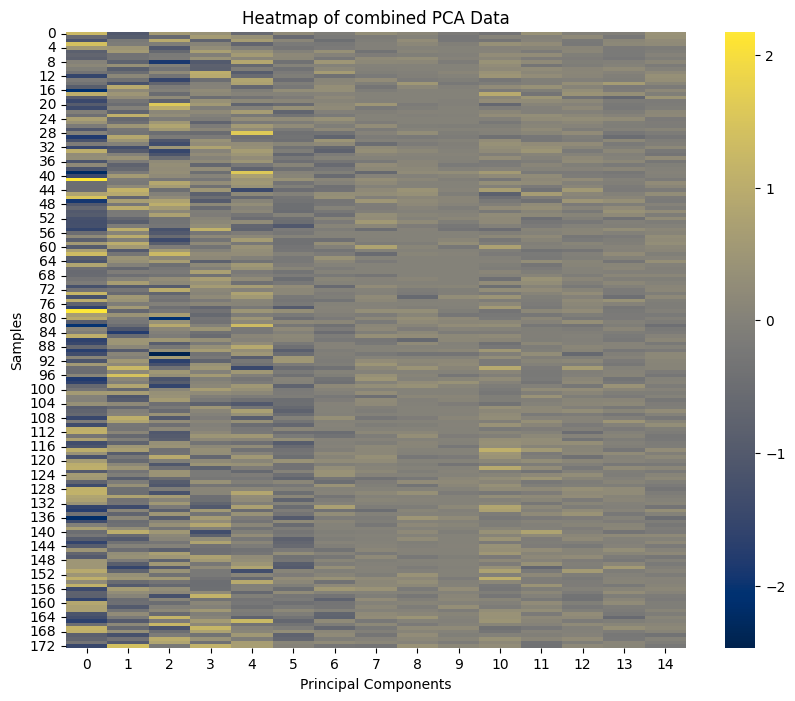

In [38]:
print("data size of combined sample: ", combined_sample.size)

# visualize result, split into 3 parts with titles
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.heatmap(cna_sample, cmap='cividis', ax=ax[0])
ax[0].set_title('CNA Sample')
sns.heatmap(dm_sample, cmap='cividis', ax=ax[1])
ax[1].set_title('DM Sample')
sns.heatmap(mrna_sample, cmap='cividis', ax=ax[2])
ax[2].set_title('MRNA Sample')
plt.figure(figsize=(10, 8))
sns.heatmap(combined_sample, cmap='cividis')

# Labels and title
plt.title("Heatmap of combined PCA Data")
plt.xlabel("Principal Components")
plt.ylabel("Samples")

# Show the plot
plt.show()